In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text, keep only tokens
tokenized_datasets.set_format("torch")  # Set format to PyTorch tensors

vocab_size=tokenizer.vocab_size+1
device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [2]:
import math
from continous_diffusion import Diffusion,DiffusionTransformer,Loss,Embedder,CauchySchedule

embed_dim=128
qkv_dim=1024
num_heads=8
cond_dim=16
n_blocks=8

dit=DiffusionTransformer(embed_dim,qkv_dim,num_heads,cond_dim,n_blocks)
embedder=Embedder(vocab_size,embed_dim)
schedule=CauchySchedule(0.01,200,0,0.3,math.log(vocab_size),0)
loss=Loss(embedder,schedule)
model=Diffusion(dit,loss).to(device)

print(model.n_parameters)

4461088


In [3]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=256, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

# Learning-rate scheduling
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LinearLR, ExponentialLR
warmup=LinearLR(optimizer,1e-3,1,5)
decay=ExponentialLR(optimizer,gamma=0.9)
scheduler=SequentialLR(optimizer,[warmup,decay],milestones=[6])

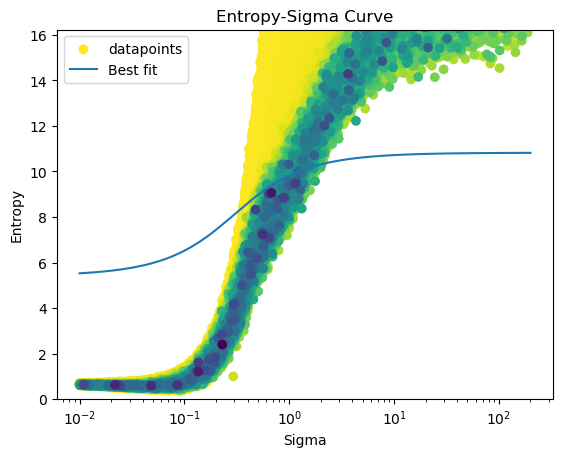

lr: [1.0941898913151244e-05]
Step: 1350,  Loss: 5.281580924987793
Step: 1351,  Loss: 5.410937309265137
Step: 1352,  Loss: 4.866806507110596
Step: 1353,  Loss: 4.965793609619141
Step: 1354,  Loss: 5.104321479797363
Step: 1355,  Loss: 5.211642265319824
Step: 1356,  Loss: 5.018982410430908
Step: 1357,  Loss: 5.4471893310546875
Step: 1358,  Loss: 4.943559646606445
Step: 1359,  Loss: 5.165575981140137
Step: 1360,  Loss: nan
Step: 1361,  Loss: 5.249871253967285
Step: 1362,  Loss: 5.356201648712158
Step: 1363,  Loss: 5.305438995361328
Step: 1364,  Loss: 5.028961181640625
Step: 1365,  Loss: 4.853769779205322
Step: 1366,  Loss: 4.942817687988281
Step: 1367,  Loss: 5.31638765335083
Step: 1368,  Loss: 4.782884120941162
Step: 1369,  Loss: 5.076591968536377
Step: 1370,  Loss: 5.33640193939209
Step: 1371,  Loss: 5.100276947021484
Step: 1372,  Loss: 4.975229740142822
Step: 1373,  Loss: 5.140356063842773
Step: 1374,  Loss: 4.880915641784668
Step: 1375,  Loss: 5.012307167053223
Step: 1376,  Loss: 5.314

In [4]:
schedule_update_frequency=2000

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            schedule.update_optimal_parameters()

        if i%50==0 and i!=0:
            scheduler.step()
            clear_output(wait=True) 
            schedule.plot_entropy_time_curve()
            print(f"lr: {scheduler.get_last_lr()}")

        print(f"Step: {i},  Loss: {loss.item()}")


In [ ]:
out=model.generate(1,64,1000,device=device)
out=model.un_embedder(out)
sampler=torch.distributions.Categorical(logits=out)
sample=sampler.sample().tolist()
tokenizer.batch_decode(sample)

100%|██████████| 999/999 [00:06<00:00, 157.86it/s]


[' Min buildingaux dotted Dance Strike declaring Doing pilots399 implements outsidersarna HearthBack Ball magrust led exasper Some Grounds 1966 recognizeWal ambul cells routed Bruce announcements node InterPUT Micha essentially agentsmoil Ident Slow rows stockedSaid clan MoonsspellRu UnlikeChan month Electronics neck insistence Lei Will conserve steps QWMHeatsoftpediaimportCompar wants']

In [ ]:
model.schedule.optimal_parameters

Parameter containing:
tensor([ 0.3114,  0.1103,  2.9068, -0.4341])

In [ ]:
model.n_parameters

712192